In [1]:
# Required Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
import joblib
import shutil

In [2]:

from google.colab import files
uploaded = files.upload()

# Load datasets
students_df = pd.read_csv('students_final.csv')
courses_df = pd.read_csv('courses_final.csv')
history_df = pd.read_csv('student_course_history_final.csv')

Saving courses_final.csv to courses_final.csv
Saving student_course_history_final.csv to student_course_history_final.csv
Saving students_final.csv to students_final.csv


<ipython-input-3-c39dfc0d670b>:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='success', data=merged_df, palette='viridis')


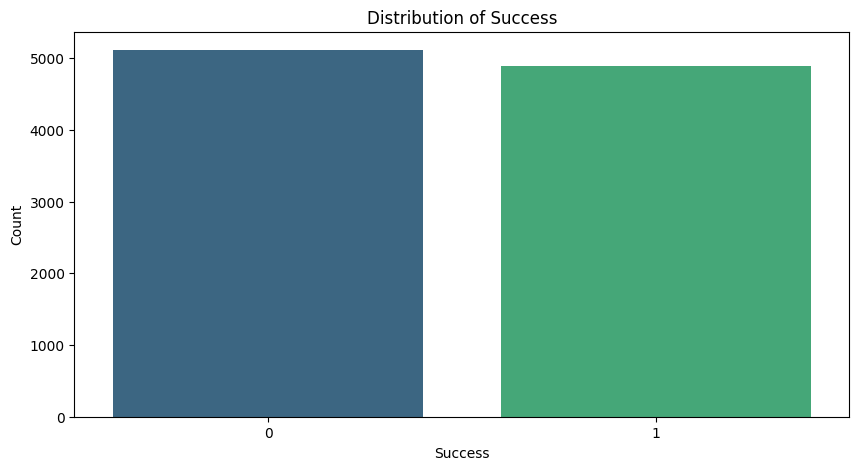

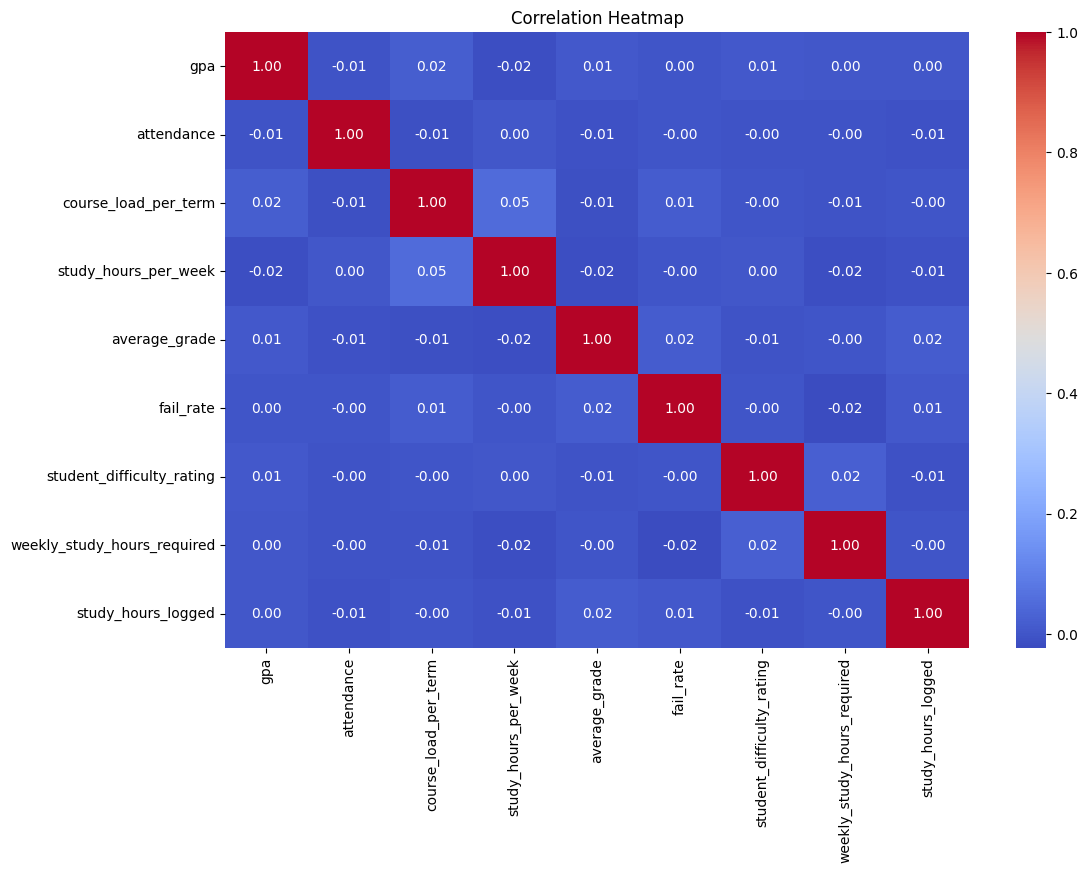

In [3]:

# Merge datasets
merged_df = history_df.merge(students_df, on='student_id').merge(courses_df, on='course_id')

# Features and target selection
X = merged_df[[
    'gpa', 'attendance', 'course_load_per_term', 'study_hours_per_week',
    'average_grade', 'fail_rate', 'student_difficulty_rating',
    'weekly_study_hours_required', 'study_hours_logged',
    'enrollment_status', 'major_x', 'highest_degree',
    'course_difficulty_experience', 'career_goal', 'prerequisite_level',
    'delivery_mode', 'completion_status'
]]
y = merged_df['success']

# Numeric and categorical features
numeric_features = [
    'gpa', 'attendance', 'course_load_per_term', 'study_hours_per_week',
    'average_grade', 'fail_rate', 'student_difficulty_rating',
    'weekly_study_hours_required', 'study_hours_logged'
]

categorical_features = [
    'enrollment_status', 'major_x', 'highest_degree',
    'course_difficulty_experience', 'career_goal',
    'prerequisite_level', 'delivery_mode', 'completion_status'
]


# Visualization of Data distributions
plt.figure(figsize=(10, 5))
sns.countplot(x='success', data=merged_df, palette='viridis')
plt.title('Distribution of Success')
plt.xlabel('Success')
plt.ylabel('Count')
plt.show()

# Correlation Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(merged_df[numeric_features].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

# Preprocessing pipeline setup
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)







Logistic Regression Evaluation
Accuracy: 0.5205
F1 Score: 0.5148904196654273
              precision    recall  f1-score   support

           0       0.53      0.63      0.57      1023
           1       0.51      0.41      0.46       977

    accuracy                           0.52      2000
   macro avg       0.52      0.52      0.51      2000
weighted avg       0.52      0.52      0.51      2000



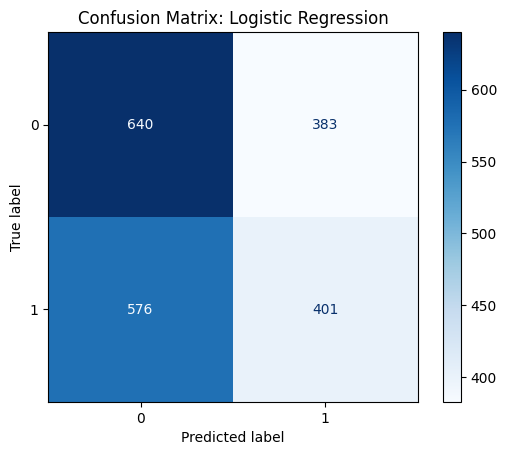


Random Forest Evaluation
Accuracy: 0.7635
F1 Score: 0.7631707208809266
              precision    recall  f1-score   support

           0       0.76      0.80      0.77      1023
           1       0.77      0.73      0.75       977

    accuracy                           0.76      2000
   macro avg       0.76      0.76      0.76      2000
weighted avg       0.76      0.76      0.76      2000



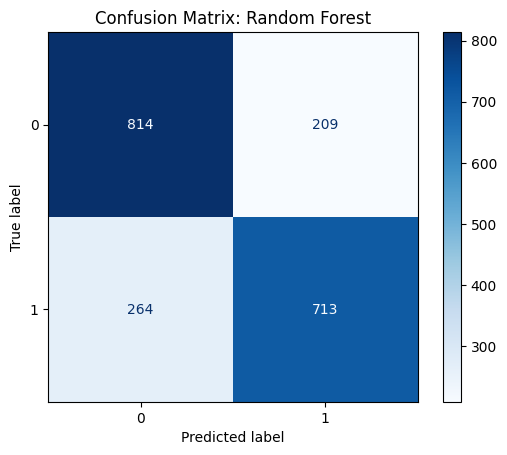


Support Vector Machine Evaluation
Accuracy: 0.5665
F1 Score: 0.5645996383715551
              precision    recall  f1-score   support

           0       0.57      0.63      0.60      1023
           1       0.56      0.50      0.53       977

    accuracy                           0.57      2000
   macro avg       0.57      0.56      0.56      2000
weighted avg       0.57      0.57      0.56      2000



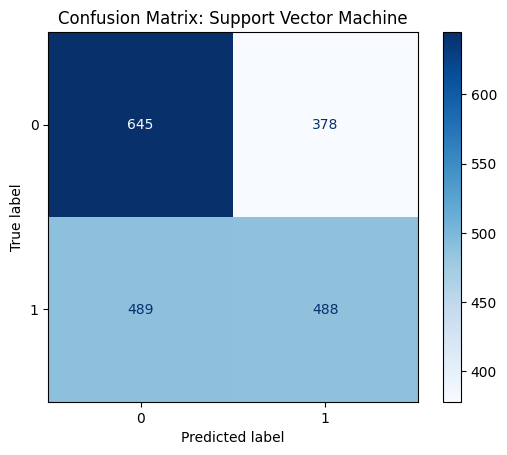

In [4]:
# Model comparison setup
models = {
    'Logistic Regression': LogisticRegression(max_iter=500),
    'Random Forest': RandomForestClassifier(n_estimators=150, max_depth=15, min_samples_split=2, random_state=42),
    'Support Vector Machine': SVC(kernel='rbf', probability=True)
}

results = {}

for name, clf in models.items():
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', clf)
    ])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    results[name] = {'Accuracy': acc, 'F1 Score': f1, 'Model': pipe}
    print(f"\n{name} Evaluation")
    print("Accuracy:", acc)
    print("F1 Score:", f1)
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe.classes_)
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix: {name}')
    plt.show()


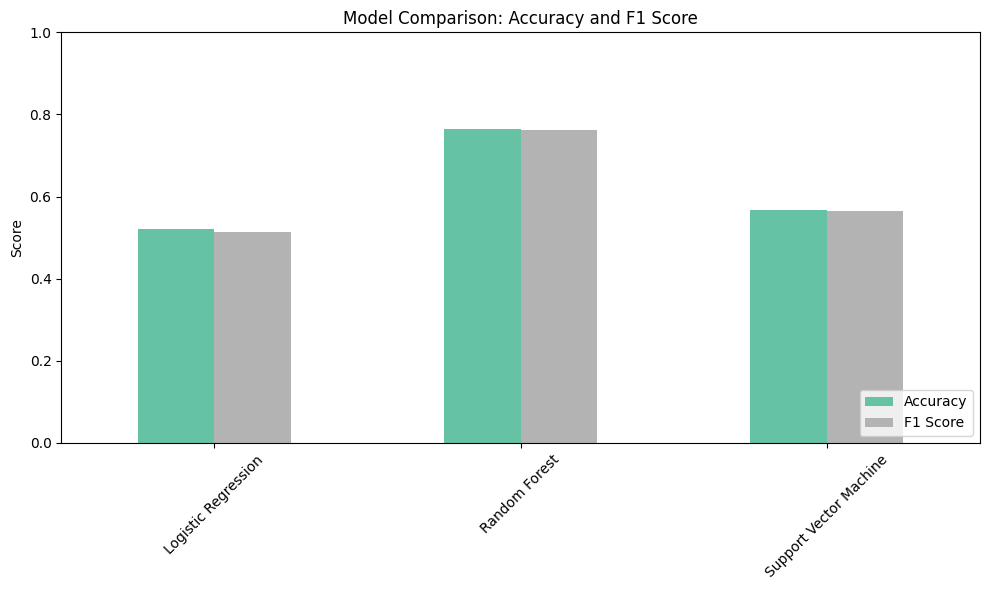

In [5]:
# Visual comparison
df_results = pd.DataFrame(results).T[['Accuracy', 'F1 Score']]
df_results.plot(kind='bar', figsize=(10, 6), colormap='Set2')
plt.title('Model Comparison: Accuracy and F1 Score')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


<ipython-input-6-80d9f8411458>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=recommendation_df, x='success', y='course_name', palette='crest')


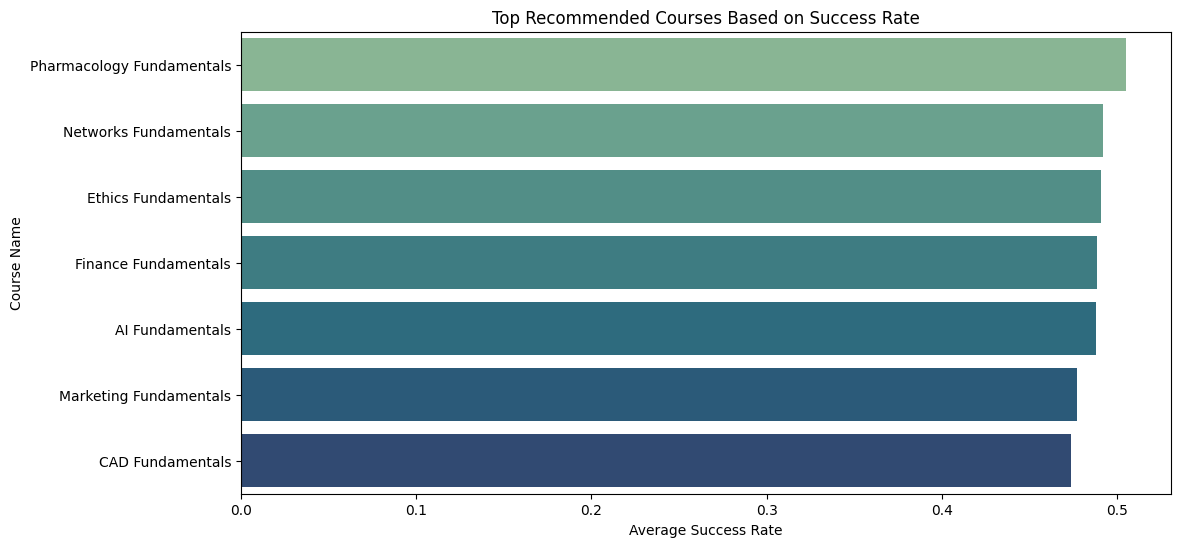

In [6]:
# Using the best model (Random Forest) for recommendations
best_model = results['Random Forest']['Model']

recommendation_df = merged_df.groupby('course_name').agg({'success': 'mean', 'popularity_score': 'mean'}).reset_index()
recommendation_df = recommendation_df.sort_values(by=['success', 'popularity_score'], ascending=[False, False]).head(10)

# Visualize top course recommendations
plt.figure(figsize=(12, 6))
sns.barplot(data=recommendation_df, x='success', y='course_name', palette='crest')
plt.xlabel('Average Success Rate')
plt.ylabel('Course Name')
plt.title('Top Recommended Courses Based on Success Rate')
plt.show()


In [8]:

# Save and export the best model
from google.colab import files
joblib.dump(best_model, 'final_rf_model.pkl')
shutil.move('final_rf_model.pkl', './final_rf_model.pkl')
files.download('final_rf_model.pkl')

#joblib.dump(best_rf_model, 'final_rf_model.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>